In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import SimpleITK as sitk
import copy


from scipy.interpolate import griddata

import time
'''Read in data as a 1, 100, 100, 3 vector field, please change the PATHOFVELOCITY to the directory path of velocity ''' 
velocity = sitk.GetArrayFromImage(sitk.ReadImage("./code+data_Q3/data/initialV/v0Spatial.mhd"))

'''Read in data as a 1, 100, 100  image, please change the PATHOFSOURCE to the directory path of source '''
source= sitk.GetArrayFromImage(sitk.ReadImage("./code+data_Q3/data/sourceImage/source.mhd"))

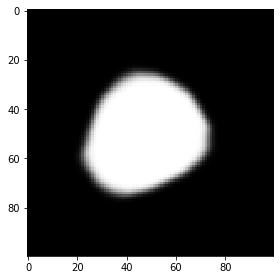

In [3]:
imshow(np.reshape(source, (100, 100)))

In [4]:
velocity = np.reshape(velocity, (100, 100, 3))
source = np.reshape(source, (100, 100))

In [5]:
# We need to use euler integration to get to the deformed image
#This is where we reshape the data to get rid of the 3rd pixel component of velocity.
def v2d(data):
    ret = []
    for row in data:
        r1 = []
        for cell in row:
            c1 = []
            for index in cell:
                if index != 0:
                    c1.append(index)
            r1.append(c1)
        ret.append(r1)
    return np.array(ret)
velocity2d = v2d(velocity)


In [6]:
velocity2d

array([[[-9.4003044e-05, -4.6192482e-04],
        [-3.5812240e-04, -8.7574450e-04],
        [-5.6039914e-04, -1.0780443e-03],
        ...,
        [ 5.8996887e-04,  9.8155206e-04],
        [ 4.2606867e-04,  5.8787270e-04],
        [ 1.8378929e-04,  6.6690613e-05]],

       [[-3.6941655e-04,  1.4752429e-04],
        [-6.0262717e-04, -2.1350756e-04],
        [-7.0049055e-04, -5.2028010e-04],
        ...,
        [ 6.1395532e-04,  7.6414086e-04],
        [ 3.0812068e-04,  7.0007518e-04],
        [-4.4303772e-05,  4.7761155e-04]],

       [[-5.4466445e-04,  7.0806872e-04],
        [-7.1387691e-04,  4.8646703e-04],
        [-7.0426287e-04,  1.5213713e-04],
        ...,
        [ 5.4023485e-04,  3.6540534e-04],
        [ 1.6193883e-04,  6.3959975e-04],
        [-2.2976636e-04,  7.6362304e-04]],

       ...,

       [[ 6.5645762e-04, -1.1894247e-03],
        [ 5.2524731e-04, -1.3223113e-03],
        [ 2.3726607e-04, -1.1410262e-03],
        ...,
        [ 7.8074168e-05,  4.9788971e-04],
     

In [7]:
# differences

def fd_x(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c, 2))
    d[:, 1:c] = u[:,1:c]-u[:, 0:c-1]
    d[:, 0] = u[:, 0]-u[:,c-1]
    return d

def fd_y(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c, 2))
    d[1:r, :] = u[1:r, :]-u[0:r-1, :]
    d[0, :] = u[0, :]-u[r-1, :]
    return d

def ret_jacobian(diffx, diffy):
    return np.stack((diffx, diffy), axis=2)

def component1(velos):
    
    jacob = ret_jacobian(fd_x(velos), fd_y(velos))
    ret = np.empty((100, 100, 2, 1))
    for row in range(jacob.shape[0]):
        for col in range(jacob.shape[1]):
            #jacob[row][col] = 2x2 matrix
            #velos[row][col] = array length 2 (1x2)
            v = np.reshape(velos[row][col], (2, 1))
            j = jacob[row][col].T
            ret[row][col] = np.dot(j, v)
    return np.reshape(ret, (100, 100, 2))
            

#jacobian: 
# 1. calc the forward difference in x for every v [dvx/dx, dvx/dx]
# 2. calc the forward difference in y for every v


jacobian = ret_jacobian(fd_x(velocity2d), fd_y(velocity2d))
comp1 = component1(velocity2d)
comp1

array([[[ 1.69207217e-07, -1.83606227e-07],
        [ 3.72418149e-07, -2.64138993e-07],
        [ 3.70875475e-07, -2.37608116e-07],
        ...,
        [ 7.80465065e-08, -1.13774509e-07],
        [-1.07684502e-07, -3.08159339e-08],
        [-5.90654512e-08, -6.78261412e-08]],

       [[ 7.94718590e-08,  2.11848245e-07],
        [ 1.92742677e-07,  7.61750096e-08],
        [ 1.41439139e-07, -7.53023515e-08],
        ...,
        [-9.86392891e-08, -9.98119522e-08],
        [-1.76806434e-07,  5.88102133e-08],
        [-9.33261500e-08,  2.06116566e-07]],

       [[ 4.74262387e-08,  4.27162443e-07],
        [ 6.66775402e-08,  4.98710894e-07],
        [-7.34472374e-09,  3.37755765e-07],
        ...,
        [-1.74468497e-07,  4.81992848e-08],
        [-1.54758688e-07,  5.72265174e-09],
        [-5.16228294e-08,  1.89908584e-07]],

       ...,

       [[ 6.93393087e-08,  1.59262529e-07],
        [ 1.05719695e-07,  6.10429621e-07],
        [ 1.76915412e-07,  6.59716254e-07],
        ...,
     

In [8]:
def compute_A(velos):
    ret = np.empty((100, 100, 2, 2))
    for row in range(velos.shape[0]):
        for col in range(velos.shape[1]):
            v = np.reshape(velos[row][col], (2, 1))
            ret[row][col] = np.dot(v, v.T)
    return ret

def fd_x_A(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c, 2, 2))
    d[:, 1:c] = u[:,1:c]-u[:, 0:c-1]
    d[:, 0] = u[:, 0]-u[:,c-1]
    return d

def fd_y_A(u):
    r = u.shape[0]
    c = u.shape[1]
    d = np.zeros((r, c, 2, 2))
    d[1:r, :] = u[1:r, :]-u[0:r-1, :]
    d[0, :] = u[0, :]-u[r-1, :]
    return d

def component2(velos):
    A = compute_A(velos)
    diff_x_A = fd_x_A(A)
    diff_y_A = fd_y_A(A)
    ret = np.empty((100, 100, 2))
    for row in range(A.shape[0]):
        for col in range(A.shape[1]):
            ret[row][col][0] = diff_x_A[row][col][0][0] + diff_y_A[row][col][1][0]
            ret[row][col][1] = diff_x_A[row][col][0][1] + diff_y_A[row][col][1][1]
    return ret

In [9]:
def LPFilter(size, image):
    blank_image = np.zeros(image.shape)
    acceptable = list(range(int(image.shape[0]/2 - size/2), int(image.shape[0]/2 + size/2)))
    for r in acceptable:
        for c in acceptable:
            blank_image[r][c] = [1, 1]
    return blank_image

def dvdt(velos):
    total = component1(velos) + component2(velos)
    fourier_image = np.fft.fft2(total)
    fourier_image_shifted = np.fft.fftshift(fourier_image)
    fourier_image_shifted = fourier_image_shifted * LPFilter(16, fourier_image_shifted)
    inverse_filter = np.real(np.fft.ifft2(np.fft.ifftshift(fourier_image_shifted)))
    return -1* inverse_filter
dvdt(velocity2d)

array([[[-3.15032579e-05,  2.44835349e-05],
        [-2.40426476e-05,  2.84187316e-05],
        [-1.37597955e-05,  2.15515087e-05],
        ...,
        [-1.53662678e-05, -2.98173721e-05],
        [-2.83023374e-05, -9.93261631e-06],
        [-3.35522008e-05,  1.03321147e-05]],

       [[-2.12733160e-05,  1.15940567e-05],
        [-1.12210823e-05,  4.38443364e-05],
        [-1.99838374e-06,  6.13492491e-05],
        ...,
        [-2.79430331e-05, -8.86906840e-05],
        [-3.24725344e-05, -6.51051680e-05],
        [-2.94069283e-05, -2.81297889e-05]],

       [[ 3.29288008e-06, -9.06914305e-06],
        [ 1.13977916e-05,  2.45166669e-05],
        [ 1.50417226e-05,  5.06115989e-05],
        ...,
        [-2.84735477e-05, -7.73464337e-05],
        [-1.97150313e-05, -6.74039151e-05],
        [-7.97138981e-06, -4.24247017e-05]],

       ...,

       [[ 2.83670474e-05, -2.15257172e-06],
        [ 2.81686219e-05, -9.79831954e-06],
        [ 2.27295622e-05, -1.13963459e-05],
        ...,
     

In [10]:
velocity2d.shape

(100, 100, 2)

In [11]:
def initialize_mapping(row, col):
    ret = np.empty((100, 100, 2))
    for r in range(row):
        for c in range(col):
            ret[r][c] = (r, c)
    return ret #.reshape(100*100, 2)
a = initialize_mapping(100, 100)

In [12]:
def doit(step, source_image, initial_velocity):
    t = 0
    
    velocity = copy.deepcopy(initial_velocity)
    
    image = copy.deepcopy(source_image)
    
    grid_x, grid_y = np.mgrid[0:99:100j, 0:99:100j]
    points = initialize_mapping(100, 100)# (100, 100, 2)
    
    for a in np.arange(0, 1, step):
        
        coord_mapping = points + velocity * step#(100, 100, 2)
        
        image = griddata(points.reshape(100*100, 2), image.reshape(100*100), coord_mapping.reshape(100*100, 2), fill_value=0)
        
        image = image.reshape((100, 100))
        delta_velocity = dvdt(velocity) * step
        velocity = velocity + delta_velocity

    return image.T
        
        

In [13]:
velocity = np.reshape(velocity, (100, 100, 3))
source = np.reshape(source, (100, 100))
velocity2d = v2d(velocity)
deformed_image = doit(0.1, source, velocity2d)

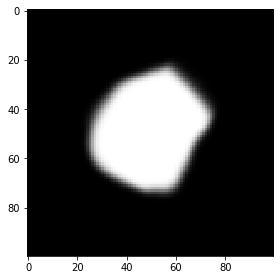

In [14]:
imshow(deformed_image, cmap='gray')

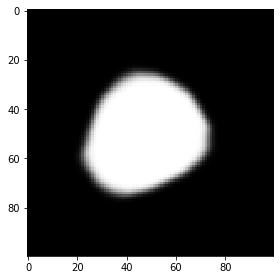

In [15]:
imshow(np.reshape(source, (100, 100)))